<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Breast_Diagnosis_Model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !pip install tensorflow-addons

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools
from PIL import Image

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Define your data directory path
data_dir = '/content/drive/My Drive/data2'

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' does not exist.")

# Get the list of class names (subfolders)
classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]

# Resize the image sizes to different resolutions
# resolutions = [(32, 32), (64,64), (128,128), (256,256)]
resolutions = [(32, 32)]

# Function to resize images
def resize_images(directory, size):
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        for img_file in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_file)
            try:
                img = Image.open(img_path)
                img = img.resize(size)
                img.save(img_path)  # overwrite original image with resized image
            except (IOError, UnidentifiedImageError):
                print(f"Could not process file {img_path}")

# Function to build and compile the CNN model
def build_compile_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', precision, recall, f1_score])
    return model

# Custom metrics
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

def plot_confusion_matrices(cm_train, cm_test, classes, train_title, test_title, filename, font_size=10):
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))

    # Training confusion matrix
    ax[0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    ax[0].set_title(train_title, fontsize=font_size)
    tick_marks = np.arange(len(classes))
    ax[0].set_xticks(tick_marks)
    ax[0].set_yticks(tick_marks)
    ax[0].set_xticklabels(classes, rotation=45, fontsize=font_size)
    ax[0].set_yticklabels(classes, fontsize=font_size)
    fmt = 'd'
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        ax[0].text(j, i, format(cm_train[i, j], fmt),
                   horizontalalignment="center",
                   color="white" if cm_train[i, j] > thresh else "black",
                   fontsize=font_size)
    ax[0].set_ylabel('True label', fontsize=font_size)
    ax[0].set_xlabel('Predicted label', fontsize=font_size)
    ax[0].grid(False)

    # Testing confusion matrix
    ax[1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    ax[1].set_title(test_title, fontsize=font_size)
    ax[1].set_xticks(tick_marks)
    ax[1].set_yticks(tick_marks)
    ax[1].set_xticklabels(classes, rotation=45, fontsize=font_size)
    ax[1].set_yticklabels(classes, fontsize=font_size)
    fmt = 'd'
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        ax[1].text(j, i, format(cm_test[i, j], fmt),
                   horizontalalignment="center",
                   color="white" if cm_test[i, j] > thresh else "black",
                   fontsize=font_size)
    ax[1].set_ylabel('True label', fontsize=font_size)
    ax[1].set_xlabel('Predicted label', fontsize=font_size)
    ax[1].grid(False)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Function to draw subplots for each class at different resolutions
def plot_class_resolutions(data_dir, classes, resolutions):
    fig, axes = plt.subplots(len(classes), len(resolutions), figsize=(12,12))

    # Iterate over each class
    for class_idx, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        img_files = os.listdir(cls_dir)
        random_img_file = random.choice(img_files)  # Randomly select an image from the class

        # Iterate over each resolution
        for res_idx, resolution in enumerate(resolutions):
            img = load_resized_image(data_dir, cls, random_img_file, resolution)

            # Plot the image in the corresponding subplot
            ax = axes[class_idx, res_idx]
            ax.imshow(img)
            ax.axis('off')  # Hide axes ticks
            if class_idx == 0:
                ax.set_title(f'{resolution[0]}x{resolution[1]}', fontsize=11)  # Set resolution as title for the top row
            if res_idx == 0:
                ax.set_ylabel(cls, fontsize=11)  # Set class name as y-label for the first column

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.savefig('class_resolutions.png')
    plt.show()

# Function to resize and load a single image
def load_resized_image(directory, cls, img_file, size):
    img_path = os.path.join(directory, cls, img_file)
    img = Image.open(img_path)
    img = img.resize(size)
    return img

# Lists to store results
histories = []
confusion_matrices_train = []
confusion_matrices_test = []
classification_reports_train = []
classification_reports_test = []

# Run the model 5 times with different resolutions
for resolution in resolutions:
    print(f"Running model with resolution {resolution}...")

    # Resize images
    resize_images(data_dir, size=resolution)

    # Prepare data
    X, y = [], []
    label_map = {cls: idx for idx, cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for img_file in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_file)
            img = load_img(img_path)
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(label_map[cls])

    X = np.array(X).astype('float32') / 255.0
    y = np.array(y).astype('int')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=23)

    # Build and compile model
    model = build_compile_model(input_shape=(resolution[0], resolution[1], 3), num_classes=len(classes))

    # Save model architecture
    plot_model(model, to_file=f'model_architecture_{resolution}.png', show_shapes=True, show_layer_names=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    # Save history
    histories.append(history)

    # Compute confusion matrices
    train_predictions = np.argmax(model.predict(X_train), axis=1)
    test_predictions = np.argmax(model.predict(X_test), axis=1)
    cm_train = confusion_matrix(y_train, train_predictions)
    cm_test = confusion_matrix(y_test, test_predictions)
    confusion_matrices_train.append(cm_train)
    confusion_matrices_test.append(cm_test)

    # Compute classification reports
    train_report = classification_report(y_train, train_predictions, target_names=classes, output_dict=True)
    test_report = classification_report(y_test, test_predictions, target_names=classes, output_dict=True)
    classification_reports_train.append(train_report)
    classification_reports_test.append(test_report)


Running model with resolution (32, 32)...
Epoch 1/10
67/67 [==============================] - 4s 36ms/step - loss: 0.9863 - accuracy: 0.5093 - precision: 108656720.0000 - recall: 1.5266 - f1_score: 2.1335 - val_loss: 0.7286 - val_accuracy: 0.6772 - val_precision: 0.7320 - val_recall: 1.0322 - val_f1_score: 0.8448
Epoch 2/10
67/67 [==============================] - 3s 41ms/step - loss: 0.6817 - accuracy: 0.6964 - precision: 0.7083 - recall: 1.0738 - f1_score: 0.8436 - val_loss: 0.6115 - val_accuracy: 0.7141 - val_precision: 0.6960 - val_recall: 1.1717 - val_f1_score: 0.8659
Epoch 3/10
67/67 [==============================] - 4s 54ms/step - loss: 0.5922 - accuracy: 0.7523 - precision: 0.6550 - recall: 1.0818 - f1_score: 0.8085 - val_loss: 0.5649 - val_accuracy: 0.7641 - val_precision: 0.5868 - val_recall: 1.0186 - val_f1_score: 0.7397
Epoch 4/10
67/67 [==============================] - 4s 66ms/step - loss: 0.5619 - accuracy: 0.7607 - precision: 0.6328 - recall: 1.0664 - f1_score: 0.7854 

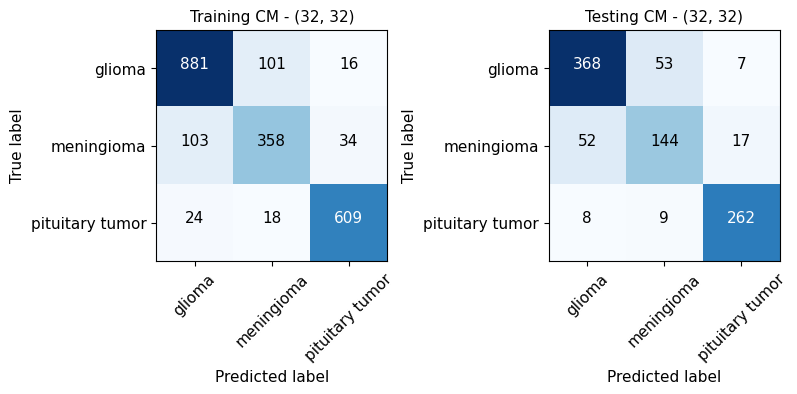

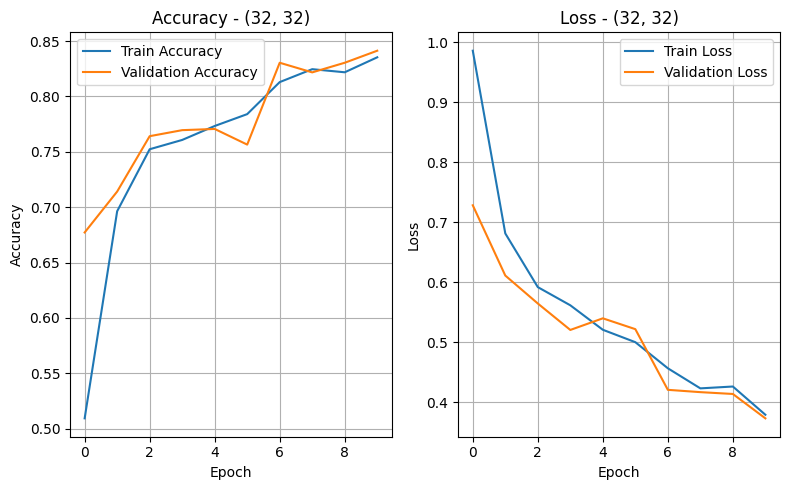

In [9]:
from tensorflow.keras.utils import plot_model

# Save the confusion matrices as PNG
plot_confusion_matrices(cm_train, cm_test, classes, f'Training CM - {resolution}', f'Testing CM - {resolution}', f'confusion_matrices_{resolution}.png', font_size=11)

# Save the CNN architecture as a PNG figure
plot_model(model, to_file=f'model_architecture_{resolution}.png', show_shapes=True, show_layer_names=True)

# Plot convergence curves (accuracy and loss in one figure as subplots) and save as PNG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title(f'Accuracy - {resolution}')
ax1.grid()

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title(f'Loss - {resolution}')
ax2.grid()

plt.tight_layout()
plt.savefig(f'convergence_curve_{resolution}.png')
plt.show()
